<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/new-dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!git clone https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


In [60]:
import os, math, json, random, time, copy
from pathlib import Path # Import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

CSV_TRAIN = Path("/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv")
CSV_VAL   = Path("/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv")
CSV_TEST  = Path("/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv")
LABEL_MAP = Path("/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json")
DATA_DIR = Path("/content/ann-visual-emotion/data/raw/EmoSet")

assert CSV_TRAIN.exists(), f"Missing {CSV_TRAIN}"
assert CSV_VAL.exists(),   f"Missing {CSV_VAL}"
assert CSV_TEST.exists(),  f"Missing {CSV_TEST}"
assert LABEL_MAP.exists(), f"Missing {LABEL_MAP}"

# Image size for FER tiny images
IMG_SZ = 48
IN_CH  = 1          # grayscale
NUM_CLASSES = 7     # adjust if your label_map differs
BATCH = 128
EPOCHS = 30
MAX_LR = 3e-3
WEIGHT_DECAY = 1e-2
DROPOUT = 0.2

OUT_DIR = Path('/mnt/data/fer_runs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = OUT_DIR/'fernetv2_best.pt'

Device: cuda


In [61]:

def read_label_map(path):
    with open(path, 'r') as f:
        lm = json.load(f)
    # accepts {"label_to_idx": {...}} or {"labels": [...]} or direct {label: idx}
    if 'label_to_idx' in lm:
        str2idx = lm['label_to_idx']
    elif 'labels' in lm and isinstance(lm['labels'], list):
        str2idx = {k:i for i,k in enumerate(lm['labels'])}
    else:
        # assume already mapping
        str2idx = lm
    idx2str = {v:k for k,v in str2idx.items()}
    return str2idx, idx2str

str2idx, idx2str = read_label_map(LABEL_MAP)
classes = [idx2str[i] for i in range(len(idx2str))]
NUM_CLASSES = len(classes)
print('classes:', classes)


classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [62]:

def autodetect_columns(df):
    path_cols  = ['filepath', 'image', 'img', 'path', 'file']
    label_cols = ['label', 'emotion', 'class', 'target', 'y']
    pcol = None; lcol = None
    for c in df.columns:
        cl = c.lower()
        if pcol is None and cl in path_cols: pcol = c
        if lcol is None and cl in label_cols: lcol = c
    # Fallback: use first two columns if not found
    if pcol is None: pcol = df.columns[0]
    if lcol is None: lcol = df.columns[1]
    return pcol, lcol

def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    pcol, lcol = autodetect_columns(df)
    return df[[pcol, lcol]].rename(columns={pcol:'path', lcol:'label'})

df_tr = load_csv(CSV_TRAIN)
df_va = load_csv(CSV_VAL)
df_te = load_csv(CSV_TEST)

print('Train shape:', df_tr.shape, 'Val shape:', df_va.shape, 'Test shape:', df_te.shape)
print(df_tr.head())


Train shape: (28821, 2) Val shape: (5653, 2) Test shape: (1413, 2)
                    path  label
0  train/angry/14147.jpg  angry
1  train/angry/24084.jpg  angry
2    train/angry/823.jpg  angry
3  train/angry/19463.jpg  angry
4  train/angry/30797.jpg  angry


In [63]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path

class CSVDataset(Dataset):
    def __init__(self, df, str2idx, transform=None, images_root=""):
        self.df = df.reset_index(drop=True)
        self.str2idx = str2idx
        self.transform = transform
        self.images_root = images_root # Store images_root

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_path_rel = row['path']
        # Construct full path using images_root
        img_path = Path(self.images_root) / img_path_rel
        label = row['label']
        # convert label -> idx
        if isinstance(label, str):
            y = self.str2idx[label]
        else:
            y = int(label)
        # open image
        with Image.open(img_path) as im:
            im = im.convert('L')  # grayscale
            im = im.resize((IMG_SZ, IMG_SZ), resample=Image.BILINEAR)
        if self.transform:
            im = self.transform(im)
        else:
            im = transforms.ToTensor()(im)
        return im, y

# Modify estimate_mean_std to accept images_root
def estimate_mean_std(df, max_items=2048, images_root=""):
    # simple estimator on a subset
    idxs = np.random.choice(len(df), size=min(max_items, len(df)), replace=False)
    pix = []
    for i in idxs:
        p_rel = df.iloc[i]['path']
        # Construct full path using images_root
        p = Path(images_root) / p_rel
        with Image.open(p) as im:
            im = im.convert('L').resize((IMG_SZ, IMG_SZ), resample=Image.BILINEAR)
            arr = np.array(im, dtype=np.float32)/255.0
            pix.append(arr)
    arr = np.stack(pix, 0)  # N,H,W
    mean = float(arr.mean())
    std  = float(arr.std() + 1e-8)
    return mean, std

# Pass DATA_DIR to estimate_mean_std
probe_mean, probe_std = estimate_mean_std(df_tr, max_items=1024, images_root=DATA_DIR)
print('Estimated mean/std:', probe_mean, probe_std)

Estimated mean/std: 0.5093752145767212 0.25562435388565063


In [64]:
mean, std = probe_mean, probe_std
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value=0)
])
eval_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Pass DATA_DIR as images_root
ds_tr = CSVDataset(df_tr, str2idx, transform=train_tf, images_root=DATA_DIR)
ds_va = CSVDataset(df_va, str2idx, transform=eval_tf, images_root=DATA_DIR)
ds_te = CSVDataset(df_te, str2idx, transform=eval_tf, images_root=DATA_DIR)

# Optional: class balance report
y_tr = [ds_tr.df.iloc[i]['label'] for i in range(len(ds_tr))]
print('Train label counts:', pd.Series(y_tr).value_counts().to_dict())

Train label counts: {'happy': 7164, 'neutral': 4982, 'sad': 4938, 'fear': 4103, 'angry': 3993, 'surprise': 3205, 'disgust': 436}


In [65]:

# WeightedRandomSampler if imbalanced
# Toggle this True/False
USE_SAMPLER = True

if USE_SAMPLER:
    # Map string labels -> idx
    y_idx = [str2idx[y] if isinstance(y, str) else int(y) for y in y_tr]
    counts = np.bincount(y_idx, minlength=len(classes))
    weights = 1.0 / np.maximum(counts, 1)
    sample_w = torch.DoubleTensor([weights[i] for i in y_idx])
    sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
    train_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


In [66]:

class DSConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()
    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.bn(x)
        return self.act(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = DSConv(in_ch, out_ch, stride=stride)
        self.conv2 = DSConv(out_ch, out_ch, stride=1)
        self.down = None
        if stride != 1 or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        self.act = nn.GELU()
    def forward(self, x):
        iden = x if self.down is None else self.down(x)
        x = self.conv1(x); x = self.conv2(x)
        return self.act(x + iden)

class FERNetV2(nn.Module):
    def __init__(self, in_ch=1, num_classes=7, dropout=0.2, width=32):
        super().__init__()
        c = width
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, c, 3, 1, 1, bias=False),
            nn.BatchNorm2d(c),
            nn.GELU()
        )
        self.stage1 = ResidualBlock(c,   c,   stride=1)  # 48x48
        self.down1  = ResidualBlock(c,   c,   stride=2)  # 24x24
        self.stage2 = ResidualBlock(c,   c*2, stride=1)  # 24x24
        self.down2  = ResidualBlock(c*2, c*2, stride=2)  # 12x12
        self.stage3 = ResidualBlock(c*2, c*4, stride=1)  # 12x12
        self.down3  = ResidualBlock(c*4, c*4, stride=2)  # 6x6
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(c*4, 256), nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x); x = self.down1(x)
        x = self.stage2(x); x = self.down2(x)
        x = self.stage3(x); x = self.down3(x)
        x = self.pool(x)
        return self.head(x)

model = FERNetV2(in_ch=IN_CH, num_classes=NUM_CLASSES, dropout=DROPOUT, width=32).to(device)
sum(p.numel() for p in model.parameters())/1e6


0.152519

In [67]:

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)

steps_per_epoch = max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    pct_start=0.15, div_factor=10, final_div_factor=100
)

class EMA:
    def __init__(self, model, decay=0.995):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad: self.shadow[n] = p.data.clone()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1-self.decay)
    def copy_to(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[n])

USE_EMA = True
ema = EMA(model) if USE_EMA else None


In [68]:

def train_one_epoch(model, loader, optimizer, scheduler, criterion, ema=None):
    model.train()
    total_loss, total_correct, total = 0., 0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if ema: ema.update(model)
        total_loss += loss.item() * images.size(0)
        total_correct += (logits.argmax(1) == targets).sum().item()
        total += images.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, ema=None):
    if ema:
        backup = {n: p.data.clone() for n,p in model.named_parameters() if p.requires_grad}
        ema.copy_to(model)
    model.eval()
    total_loss, total_correct, total = 0., 0, 0
    all_preds, all_tgts = [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == targets).sum().item()
        total += images.size(0)
        all_preds.append(preds.cpu()); all_tgts.append(targets.cpu())
    if ema:
        for (n,p), (_,w) in zip(model.named_parameters(), backup.items()):
            if p.requires_grad: p.data.copy_(w)
    all_preds = torch.cat(all_preds) if len(all_preds)>0 else torch.tensor([])
    all_tgts  = torch.cat(all_tgts) if len(all_tgts)>0 else torch.tensor([])
    return total_loss/total if total>0 else math.nan, (total_correct/total if total>0 else math.nan), all_preds, all_tgts


In [69]:

best_acc, best_state = 0.0, None
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, ema)
    va_loss, va_acc, va_preds, va_tgts = evaluate(model, val_loader, criterion, ema)
    macro_f1 = f1_score(va_tgts.numpy(), va_preds.numpy(), average='macro') if len(va_preds)>0 else float('nan')
    history.append((epoch, tr_loss, tr_acc, va_loss, va_acc, macro_f1))
    print(f"ep{epoch:02d} | tr_acc {tr_acc:.3f} va_acc {va_acc:.3f} va_f1 {macro_f1:.3f} va_loss {va_loss:.4f}")
    if va_acc > best_acc:
        best_acc = va_acc
        best_state = {k: v.cpu() for k,v in model.state_dict().items()}

# Save best
if best_state:
    model.load_state_dict(best_state)
    torch.save(best_state, MODEL_PATH)
    print('Saved best model to', MODEL_PATH)


ep01 | tr_acc 0.196 va_acc 0.224 va_f1 0.121 va_loss 1.9113
ep02 | tr_acc 0.265 va_acc 0.039 va_f1 0.031 va_loss 2.0818
ep03 | tr_acc 0.386 va_acc 0.183 va_f1 0.070 va_loss 1.9314
ep04 | tr_acc 0.453 va_acc 0.201 va_f1 0.102 va_loss 1.8749
ep05 | tr_acc 0.494 va_acc 0.461 va_f1 0.327 va_loss 1.5459
ep06 | tr_acc 0.528 va_acc 0.430 va_f1 0.349 va_loss 1.5658
ep07 | tr_acc 0.550 va_acc 0.496 va_f1 0.399 va_loss 1.4322
ep08 | tr_acc 0.568 va_acc 0.544 va_f1 0.482 va_loss 1.3421
ep09 | tr_acc 0.584 va_acc 0.587 va_f1 0.531 va_loss 1.2702
ep10 | tr_acc 0.596 va_acc 0.589 va_f1 0.519 va_loss 1.2730
ep11 | tr_acc 0.611 va_acc 0.579 va_f1 0.498 va_loss 1.2861
ep12 | tr_acc 0.618 va_acc 0.615 va_f1 0.565 va_loss 1.2282
ep13 | tr_acc 0.629 va_acc 0.620 va_f1 0.569 va_loss 1.2118
ep14 | tr_acc 0.634 va_acc 0.635 va_f1 0.592 va_loss 1.1929
ep15 | tr_acc 0.643 va_acc 0.634 va_f1 0.587 va_loss 1.1954
ep16 | tr_acc 0.646 va_acc 0.644 va_f1 0.610 va_loss 1.1800
ep17 | tr_acc 0.653 va_acc 0.631 va_f1 0

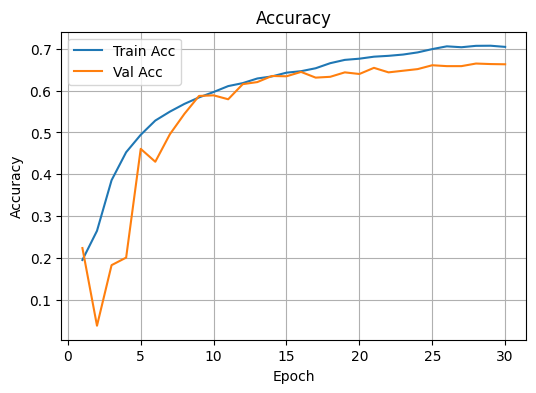

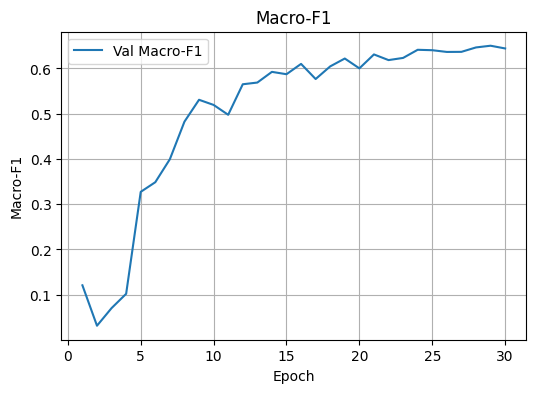

In [71]:

# Plot accuracy and macro-F1
if history:
    epochs = [h[0] for h in history]
    tr_accs = [h[2] for h in history]
    va_accs = [h[4] for h in history]
    va_f1s  = [h[5] for h in history]

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, tr_accs, label='Train Acc')
    plt.plot(epochs, va_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.show()

    # Macro-F1
    plt.figure(figsize=(6,4))
    plt.plot(epochs, va_f1s, label='Val Macro-F1')
    plt.xlabel('Epoch'); plt.ylabel('Macro-F1'); plt.title('Macro-F1'); plt.legend(); plt.grid(True)
    plt.show()


Val accuracy: 0.6633645851760127
Val macro-F1: 0.6481535062134826

Validation classification report:
              precision    recall  f1-score   support

       angry     0.5520    0.6016    0.5757       768
     disgust     0.6733    0.7640    0.7158        89
        fear     0.5283    0.4128    0.4634       814
       happy     0.8760    0.8562    0.8660      1460
     neutral     0.6044    0.6752    0.6379       973
         sad     0.5564    0.4874    0.5196       911
    surprise     0.6949    0.8354    0.7587       638

    accuracy                         0.6634      5653
   macro avg     0.6407    0.6618    0.6482      5653
weighted avg     0.6600    0.6634    0.6590      5653



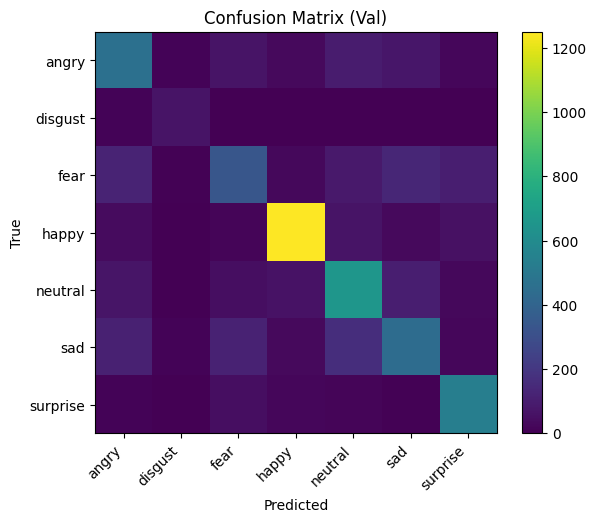

In [72]:

# Final validation report (best weights already loaded)
va_loss, va_acc, va_preds, va_tgts = evaluate(model, val_loader, criterion, ema=None)
print('Val accuracy:', va_acc)
print('Val macro-F1:', f1_score(va_tgts.numpy(), va_preds.numpy(), average='macro'))

print('\nValidation classification report:')
print(classification_report(va_tgts.numpy(), va_preds.numpy(), target_names=classes, digits=4))

cm = confusion_matrix(va_tgts.numpy(), va_preds.numpy())
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


Test accuracy: 0.6503892427459307
Test macro-F1: 0.6310486256868932

Test classification report:
              precision    recall  f1-score   support

       angry     0.5510    0.5625    0.5567       192
     disgust     0.6250    0.6818    0.6522        22
        fear     0.5287    0.4510    0.4868       204
       happy     0.8739    0.8548    0.8643       365
     neutral     0.5461    0.6337    0.5867       243
         sad     0.5309    0.4518    0.4882       228
    surprise     0.7258    0.8491    0.7826       159

    accuracy                         0.6504      1413
   macro avg     0.6259    0.6407    0.6310      1413
weighted avg     0.6480    0.6504    0.6471      1413



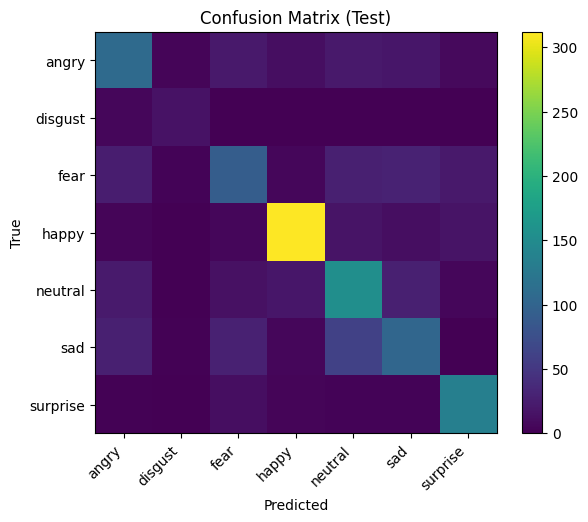

In [73]:

# Evaluate on test set
te_loss, te_acc, te_preds, te_tgts = evaluate(model, test_loader, criterion, ema=None)
print('Test accuracy:', te_acc)
print('Test macro-F1:', f1_score(te_tgts.numpy(), te_preds.numpy(), average='macro'))
print('\nTest classification report:')
print(classification_report(te_tgts.numpy(), te_preds.numpy(), target_names=classes, digits=4))

cm = confusion_matrix(te_tgts.numpy(), te_preds.numpy())
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


In [74]:

@torch.no_grad()
def predict_image(image_path, model, classes, mean, std):
    model.eval()
    im = Image.open(image_path).convert('L').resize((IMG_SZ, IMG_SZ), resample=Image.BILINEAR)
    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
    x = tfm(im).unsqueeze(0).to(device)
    logits = model(x)
    prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
    idx = int(prob.argmax())
    return classes[idx], float(prob.max()), prob